<a href="https://colab.research.google.com/github/ZamuDi0S/Filtros_FashionMNIST/blob/main/Filtros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pywt
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import fashion_mnist


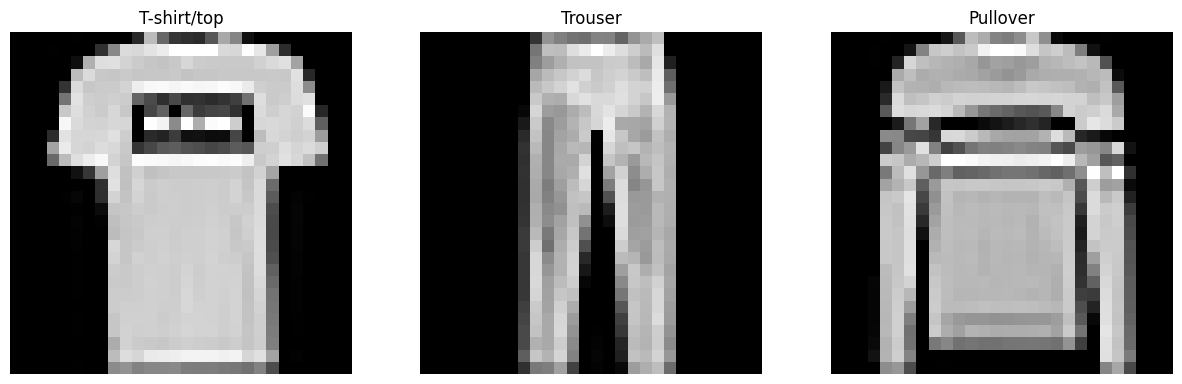

In [16]:
# Cargar el conjunto de datos Fashion-MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Definir las clases
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualizar ejemplos de cada clase
def show_sample_images():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        img = x_train[y_train == i][0]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(class_names[i])
        axes[i].axis('off')
    plt.show()

show_sample_images()

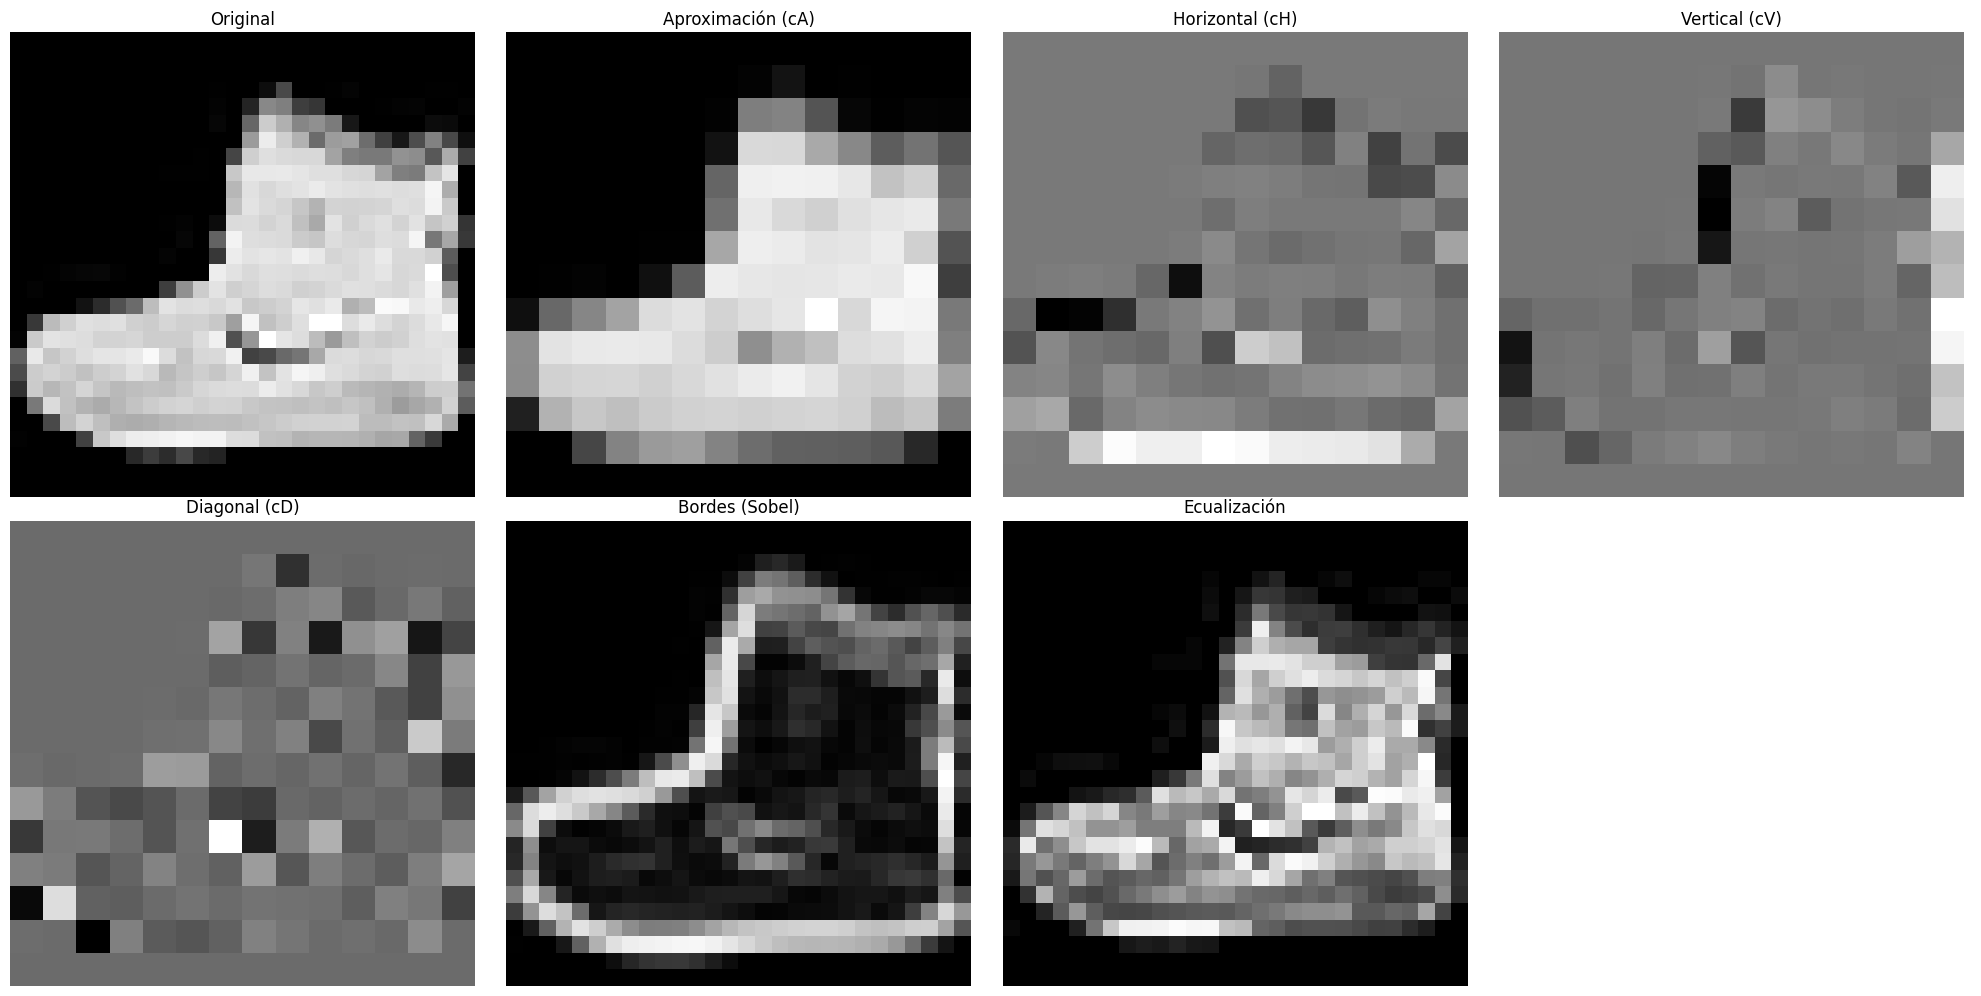

In [17]:
# Función de filtros
def apply_filters(img_array, wavelet='haar', level=1):
    img_array = img_array.astype(np.uint8)

    coeffs = pywt.wavedec2(img_array, wavelet, level=level)
    cA, (cH, cV, cD) = coeffs

    # Detección de bordes
    sobelx = cv2.Sobel(img_array, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_array, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.sqrt(sobelx**2 + sobely**2)

    #Histograma
    equ = cv2.equalizeHist(img_array)

    return edges, equ, cA, cH, cV, cD

#Imagen de ejemplo
img_test = x_train[0]

#Aplicar filtros
edges, equ, cA, cH, cV, cD = apply_filters(img_test)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].imshow(img_test, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(cA, cmap='gray')
axes[0, 1].set_title('Aproximación (cA)')
axes[0, 1].axis('off')

axes[0, 2].imshow(cH, cmap='gray')
axes[0, 2].set_title('Horizontal (cH)')
axes[0, 2].axis('off')

axes[0, 3].imshow(cV, cmap='gray')
axes[0, 3].set_title('Vertical (cV)')
axes[0, 3].axis('off')

axes[1, 0].imshow(cD, cmap='gray')
axes[1, 0].set_title('Diagonal (cD)')
axes[1, 0].axis('off')

axes[1, 1].imshow(edges, cmap='gray')
axes[1, 1].set_title('Bordes (Sobel)')
axes[1, 1].axis('off')

axes[1, 2].imshow(equ, cmap='gray')
axes[1, 2].set_title('Ecualización')
axes[1, 2].axis('off')

# Ocultar último subgráfico vacío
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

In [18]:
#Cargar solo algunas clases (ejemplo: T-shirt/top = 0, Trouser = 1, Pullover = 2)
mask = np.isin(y_train, [0, 1, 2])
X_subset = x_train[mask]
y_subset = y_train[mask]

#Redimensionar imágenes a 128x128
X_resized = []
for img in X_subset[:300]:  # Limita a 300 imágenes en total
    resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
    X_resized.append(resized.flatten())
X_resized = np.array(X_resized)

#Obtener etiquetas correspondientes
y_resized = y_subset[:300]

#Dividir y escalar
X_train, X_test, y_train_, y_test_ = train_test_split(X_resized, y_resized, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Clasificación con SVM
clf = SVC(kernel='rbf', C=1.0)
clf.fit(X_train_pca, y_train_)

#Evaluación
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test_, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.97


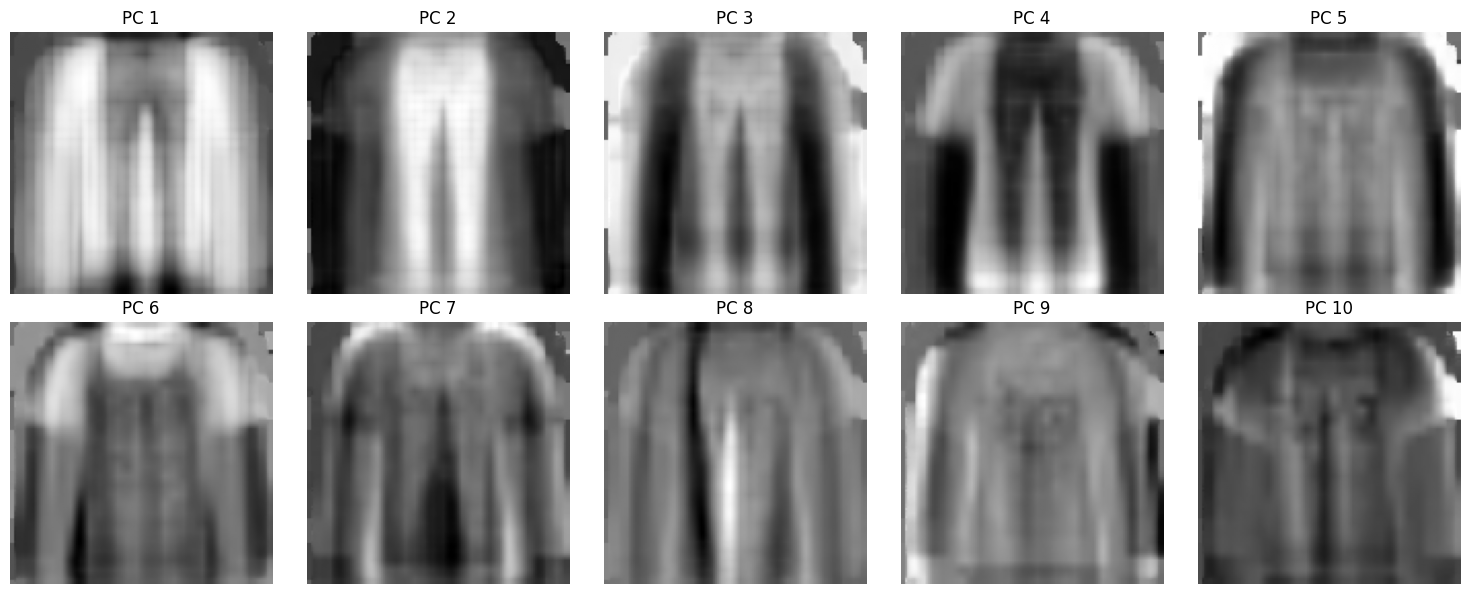

In [19]:
#Visualización de los 10 componentes principales del PCA
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    component = pca.components_[i].reshape(128, 128)  #Redimensiona cada componente
    ax.imshow(component, cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()